## Install the package dependencies before running this notebook

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""
    number of trajectories in each city
    # austin --  train: 43041 test: 6325 
    # miami -- train: 55029 test:7971
    # pittsburgh -- train: 43544 test: 6361
    # dearborn -- train: 24465 test: 3671
    # washington-dc -- train: 25744 test: 3829
    # palo-alto -- train:  11993 test:1686

    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds
    
"""

'\n    number of trajectories in each city\n    # austin --  train: 43041 test: 6325 \n    # miami -- train: 55029 test:7971\n    # pittsburgh -- train: 43544 test: 6361\n    # dearborn -- train: 24465 test: 3671\n    # washington-dc -- train: 25744 test: 3829\n    # palo-alto -- train:  11993 test:1686\n\n    trajectories sampled at 10HZ rate, input 5 seconds, output 6 seconds\n    \n'

## Create a Torch.Dataset class for the training dataset

In [2]:
from glob import glob
import pickle
import numpy as np

ROOT_PATH = "./Data/"

cities = ["austin", "miami", "pittsburgh", "dearborn", "washington-dc", "palo-alto"]
splits = ["train", "test"]

def get_city_trajectories(city="palo-alto", split="train", normalized=False):

    outputs = None
    
    if split=="train":
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = np.asarray(pickle.load(open(f_in, "rb")))
#         n = len(inputs)
#         inputs = np.asarray(inputs)[:int(n * 0.8)]
        
        f_out = ROOT_PATH + split + "/" + city + "_outputs"
        outputs = np.asarray(pickle.load(open(f_out, "rb")))
#         outputs = np.asarray(outputs)[:int(n * 0.8)]
        
    elif split == 'val':
        f_in = ROOT_PATH + 'train' + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)[int(n * 0.8):]
        
        f_out = ROOT_PATH + 'train' + "/" + city + "_outputs"
        outputs = pickle.load(open(f_out, "rb"))
        outputs = np.asarray(outputs)[int(n * 0.8):]
    
    else:
        f_in = ROOT_PATH + split + "/" + city + "_inputs"
        inputs = pickle.load(open(f_in, "rb"))
        n = len(inputs)
        inputs = np.asarray(inputs)

    return inputs, outputs

class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, city: str, split:str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.transform = transform

        self.inputs, self.outputs = get_city_trajectories(city=city, split=split, normalized=False)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):

        data = (self.inputs[idx], self.outputs[idx])
            
        if self.transform:
            data = self.transform(data)

        return data

## Create a DataLoader class for training

In [3]:
from torch import nn, optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class Pred(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(100, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 32)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 120),
            nn.ReLU(),
            nn.Linear(120, 120)
        )
        
    def forward(self, x):
        x = x.reshape(-1, 100).float()
        x = self.encoder(x)
        x = self.decoder(x)
        x = x.reshape(-1, 60, 2)
        return x

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
pred = Pred()
pred.to(device)
opt = optim.Adam(pred.parameters(), lr=1e-3)

## Training

In [5]:
import time

start = time.time()

batch_sz = 4  # batch size
for epoch in range(40):
    for city in cities:
        print(city)
        train_dataset = ArgoverseDataset(city = city, split = 'train')
        train_loader = DataLoader(train_dataset, batch_size=batch_sz)

        total_loss = 0
        for i_batch, sample_batch in enumerate(train_loader):
            i, o = sample_batch
            inp, out = i.to(device), o.to(device)
            preds = pred(inp.float())
            loss = ((preds - out) ** 2).sum()

            opt.zero_grad()
            loss.backward()
            opt.step()

            total_loss += loss.item()

    end = time.time()
    print('Time elapsed: {}'.format((end - start) / 60))
    print('epoch {} loss: {}'.format(epoch, total_loss / 203816))    

austin
miami
pittsburgh
dearborn
washington-dc
palo-alto
Time elapsed: 2.57081595659256
epoch 0 loss: 30195.15069716215
austin
miami
pittsburgh
dearborn
washington-dc
palo-alto
Time elapsed: 5.245870272318522
epoch 1 loss: 22749.236565336407
austin
miami
pittsburgh
dearborn
washington-dc
palo-alto
Time elapsed: 7.912933079401652
epoch 2 loss: 16024.36511451192
austin
miami
pittsburgh
dearborn
washington-dc
palo-alto
Time elapsed: 10.602342740694683
epoch 3 loss: 12384.892262974807
austin
miami
pittsburgh
dearborn
washington-dc
palo-alto
Time elapsed: 13.23418862024943
epoch 4 loss: 9036.392011609767
austin
miami
pittsburgh
dearborn
washington-dc
palo-alto
Time elapsed: 15.858219361305236
epoch 5 loss: 8282.051759443071
austin
miami
pittsburgh
dearborn
washington-dc
palo-alto
Time elapsed: 18.491789678732555
epoch 6 loss: 8533.021177586535
austin
miami
pittsburgh
dearborn
washington-dc
palo-alto
Time elapsed: 21.18506233294805
epoch 7 loss: 7909.96047883325
austin
miami
pittsburgh
dearb

## Validation

In [6]:
# val_dataset = ArgoverseDataset(city = 'austin', split = 'val')
# val_loader = DataLoader(val_dataset, batch_size=batch_sz)

# val_loss = 0
# for i_batch, sample_batch in enumerate(val_loader):
#     i, o = sample_batch
#     inp, out = i.to(device), o.to(device)
#     preds = pred(inp)
#     loss = ((preds - out) ** 2).sum()

#     val_loss += loss.item()
# print('loss: {}'.format(val_loss / len(val_dataset)))

## Testing

In [10]:
import pandas as pd

df = pd.read_csv(ROOT_PATH + 'submission.csv')
int_col = df.select_dtypes(include=['int'])
for col in int_col.columns.values:
    df[col] = df[col].astype('float32')
row = 0

for city in cities:
    print(city)
    test_dataset = ArgoverseDataset(city = city, split = 'test')

    for i in range(len(test_dataset.inputs)):
        data = torch.from_numpy(test_dataset.inputs[i]).to(device)
        preds = pred(data)
        df.iloc[row, 1:121] = preds.cpu().detach().numpy().ravel()
        row += 1
        
df.to_csv(ROOT_PATH + 'submission.csv', index=False)

austin
miami
pittsburgh
dearborn
washington-dc
palo-alto


## Sample a batch of data and visualize 

39
413896.1825946247
(1, 60, 2)
(60, 2)


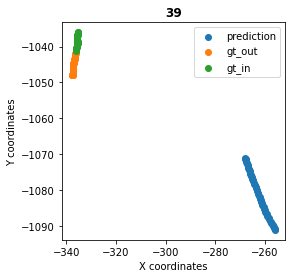

984
28327.25811416954
(1, 60, 2)
(60, 2)


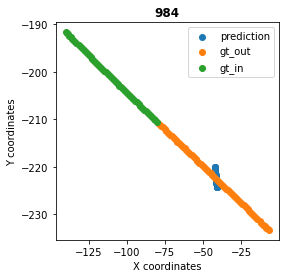

3075
129714.85896842205
(1, 60, 2)
(60, 2)


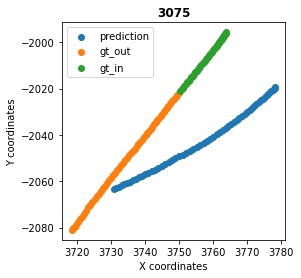

6132
48474.49989137119
(1, 60, 2)
(60, 2)


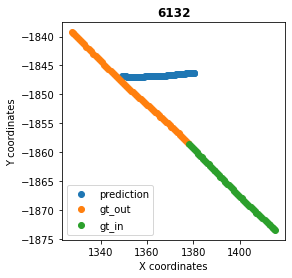

In [22]:
import matplotlib.pyplot as plt

check = [39, 984, 3075, 6132]

check_dataset = ArgoverseDataset(city = 'austin', split = 'train')
for i in range(len(check_dataset.inputs)):
    if i in check:
        data = torch.from_numpy(check_dataset.inputs[i]).to(device)
        out = check_dataset.outputs[i]
        preds = pred(data).cpu().detach().numpy()
        
        loss = ((preds - out) ** 2).sum()
        print(i)
        print(loss)
        print(preds.shape)
        print(out.shape)
        
        plt.figure(figsize=(4, 4))
        plt.scatter(preds[0, :, 0], preds[0, :, 1], label='prediction')
        plt.scatter(out[:, 0], out[:, 1], label='gt_out')
        plt.scatter(check_dataset.inputs[i][:, 0], check_dataset.inputs[i][:, 1], label='gt_in')
        plt.xlabel('X coordinates')
        plt.ylabel('Y coordinates')
        plt.title(i, fontweight ="bold")
        plt.legend()
        plt.show()
        

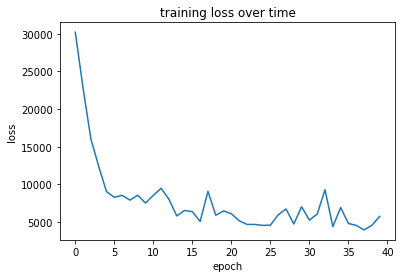

In [1]:
import matplotlib.pyplot as plt

loss_over_time = [30195.15069716215, 22749.236565336407, 16024.36511451192, 12384.892262974807,
                  9036.392011609767, 8282.051759443071, 8533.021177586535, 7909.96047883325,
                  8554.438741715541, 7525.633394016485, 8538.137926249668, 9476.19942715907,
                  8019.01293861122, 5810.399060154654, 6533.316923337074, 6372.714955296739,
                  5077.422979607126, 9078.002393526049, 5892.201587279284, 6475.244141981521,
                  6096.543173084354, 5161.303367523278, 4683.183947240653, 4673.732035488378,
                  4551.751793117595, 4578.098822617955, 5958.7015263762905, 6732.379079572472,
                  4741.237799342999, 7021.2966974634, 5253.814058198382, 6063.218152811302,
                  9290.063951731241, 4383.815530866721, 6919.929489778211, 4800.752952358283,
                  4549.801874309958, 3949.6386289254565, 4551.014492151343, 5743.232055564923]

plt.plot(loss_over_time)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('training loss over time')
plt.savefig('Data/documentation/loss_over_time.png')
plt.show()

In [11]:
# torch.save(pred, './Data/saved_models/linear_model_no_dropout')